In [8]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import itertools

In [296]:
class BS:
    def __init__(self, lattice, N, network, start_idx=0):
        self.lattice = lattice
        self.N = N
        self.network = network
        
        # create graph
        if network[0] == "watts-strogatz":
            (_, k, p) = network
            self.g = nx.watts_strogatz_graph(N, k, p)
            
            idx = start_idx
            for node in self.g:
                self.g.nodes[node]["id"] = idx
                self.g.nodes[node]["fitness"] = np.random.random()
                idx += 1
        
        # relabel nodes
        self.g = nx.relabel_nodes(self.g, mapping={i: start_idx+i for i in range(N)})
    
    def species(self):
        return dict(self.g.nodes.data("id")).values()
    
    def fitness(self):
        return self.g.nodes.data("fitness")
    
    def min_fitness(self):
        return min(self.fitness(), key=lambda x: x[1])
    
    def mutate(self):
        (i, f) = self.min_fitness()
        neighbours = list(self.g[i])
        
        # detect avalanches
#         if t == 0:
#             min_fitness = f[t,i]
#             av_size = 1
#         elif f[t,i] < min_fitness:
#             av_size += 1
#         else:
#             avs.append(av_size)
#             min_fitness = f[t,i]
#             av_size = 1
        
        self.g.node[i]["fitness"] = np.random.random()
        self.g.node[i]["id"] = self.lattice.species_idx
        self.lattice.species_idx += 1
        for nghbr in neighbours:
            self.g.node[nghbr]["fitness"] = np.random.random()
            self.g.node[nghbr]["id"] = self.lattice.species_idx
            self.lattice.species_idx += 1


In [297]:
class Lattice:
    def __init__(self, dimensions, N, network, P):
        self.dimensions = dimensions
        self.N = N
        self.P = P
        self.node_idx = (np.prod(dimensions)+1) * N
        self.species_idx = self.node_idx
        
        # create lattice
        self.lattice = nx.grid_graph(list(dimensions), periodic=False)
        self.lattice = nx.convert_node_labels_to_integers(self.lattice)
        
        # create BS network in each point of the lattice
        for (i, point) in enumerate(self.lattice):
            self.lattice.node[point]["BS"] = BS(self, N, network, start_idx=i*N)
            

    def __getitem__(self, i):
        return self.lattice.node[i]["BS"]
    

    def run(self, t_max):
        for t in range(t_max-1):
            for point in self.lattice:
                bs = self[point]
                bs.mutate()

                # migration
                if np.random.random() < self.P:
                    lattice_neighbours = self.lattice[point]
                    migrate_to = np.random.choice(lattice_neighbours)
                    bs_target = self[migrate_to]
                    
                    # TODO: find species which is not in bs_target
                    migrator = np.random.choice(bs.g.nodes)

#                     print()
#                     print(bs_target.g.nodes)
                    n1 = np.random.choice(bs_target.g.nodes)
#                     print(n1)
#                     print(bs_target.g[n1])
                    n2 = np.random.choice(list(bs_target.g[n1]))

                    # TODO: werkt nu alleen voor ring networks
                    bs_target.g.add_node(self.node_idx, **bs.g.node[migrator])
                    bs_target.g.remove_edge(n1, n2)
                    bs_target.g.add_edge(n1, self.node_idx)
                    bs_target.g.add_edge(n2, self.node_idx)
                    self.node_idx += 1

                # extinction
                if np.random.random() < self.P:
#                     print("extinc", bs.g.nodes)
                    x = np.random.choice(list(bs.g.nodes))

                    neighbours = list(bs.g[x])
                    edges = list(itertools.combinations(neighbours, 2))

                    bs.g.remove_node(x)
                    bs.g.add_edges_from(edges)
    
    def draw(self):
        nx.draw(self.lattice, with_labels=True)

In [298]:
l = Lattice((4,4), 100, ("watts-strogatz", 3, 0), 0.01)

l.run(1000)

In [299]:
l[9].species()

dict_values([22560, 31392, 31680, 32112, 32256, 32255, 32257, 38641, 38736, 38735, 38737, 37057, 37728, 37872, 37920, 37919, 37921, 37585, 10081, 32735, 32736, 20976, 20975, 20977, 39936, 39935, 40896, 41040, 41280, 41279, 41281, 39455, 39457, 9408, 9456, 11520, 18432, 18528, 18527, 12816, 13008, 13007, 13009, 12959, 12961, 946, 947, 948, 20304, 20303, 20305, 10704, 34464, 44928, 45360, 45359, 45984, 49632, 49633, 49584, 48864, 48863, 49488, 49536, 49535, 49537, 49391, 49393, 48575, 48577, 48529, 48480, 12480, 12479, 12481, 978, 4032, 16176, 16175, 23328, 23327, 25680, 25679, 25681, 25248, 25536, 25584, 33841, 33839, 33648, 33599, 33601, 33313, 33217, 32881, 22849, 38401, 25920, 6526, 38689, 33840, 33744, 32737, 10381, 37105, 22604, 11965, 24133, 38593, 31299, 49631, 41571, 30100])

In [288]:
min(l[9].spe(), key=lambda x: x[1])

(932, 0.07728991500872207)

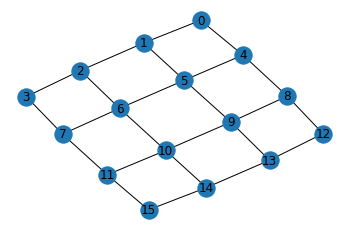

In [44]:
N_lattice = 4
N_species = 100
t_max = 10000
P_migration = 0.01

g = nx.grid_graph([N_lattice, N_lattice], periodic=False)
g = nx.convert_node_labels_to_integers(g)

fig, ax = plt.subplots()
nx.draw(g, with_labels=True)

# create BS networks
idx_node = 0
idx = 0
for node in g.nodes():
    g_species = nx.watts_strogatz_graph(N_species, 3, 0)
    
    for species in g_species:
        g_species.node[species]["id"] = idx
        g_species.node[species]["fitness"] = np.random.random()
        idx += 1
        
    g.nodes[node]["BS"] = nx.relabel_nodes(g_species, mapping={i: idx_node+i for i in range(N_species)})
    idx_node += N_species
    

    
# perform Bak-Sneppen
for t in range(t_max-1):
        
    for node in g.nodes():
        lattice_neighbours = list(g[node])    
   
        bs = g.node[node]["BS"]
        fs = nx.get_node_attributes(bs, "fitness").values()
        
        i = np.argmin(list(fs))
        i = list(nx.get_node_attributes(bs, "fitness").keys())[i]
        nghbrs = list(bs[i])
        
#         if t == 0:
#             min_fitness = f[t,i]
#             av_size = 1
#         elif f[t,i] < min_fitness:
#             av_size += 1
#         else:
#             avs.append(av_size)
#             min_fitness = f[t,i]
#             av_size = 1

        bs.node[i]["id"] = idx
        idx += 1
        bs.node[i]["fitness"] = np.random.random()
        for nghbr in nghbrs:
            bs.node[nghbr]["fitness"] = np.random.random()
            bs.node[nghbr]["id"] = idx
            idx += 1
            
            
#         age[t+1] = age[t] + 1
#         age[t+1, i] = 0
#         age[t+1, idx] = 0

        # migration
        if np.random.random() < P_migration:
            migrator = np.random.choice(bs.nodes)

            migrate_to = np.random.choice(lattice_neighbours)
            target = g.node[migrate_to]["BS"]
            
            n1 = np.random.choice(target.nodes)
            n2 = np.random.choice(list(target[n1]))
            
            target.add_node(idx_node, attr=bs.node[migrator])
            target.remove_edge(n1, n2)
            target.add_edge(n1, idx_node)
            target.add_edge(n2, idx_node)
            idx_node += 1
            
        # extinction
        if np.random.random() < P_migration:
            x = np.random.choice(bs.nodes)
            
            nghbrs = list(bs[x])
            edges = list(itertools.combinations(nghbrs, 2))
            
            bs.remove_node(x)
            bs.add_edges_from(edges)

In [46]:
g.node[0]["BS"].nodes

NodeView((6, 7, 8, 12, 17, 20, 22, 24, 26, 28, 33, 36, 39, 44, 48, 64, 66, 70, 71, 73, 87, 94, 95, 97, 98, 1678, 1792, 1894, 1907, 1926, 2153, 2186, 2197, 2296, 2353, 2368, 2419, 2496, 2502, 2507, 2536, 2567, 2618, 2625, 2660, 2670, 2675, 2792, 2840, 2858, 2881, 2913, 2914, 3034, 3089, 3103, 3125, 3151))

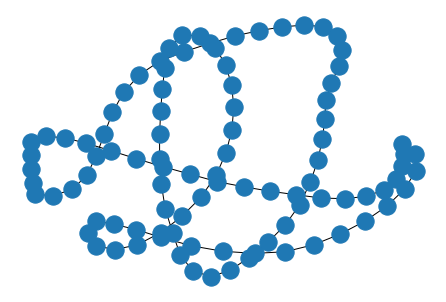

In [45]:
nx.draw(g.node[3]["BS"])

In [47]:
nr_species = [len(g.node[i]["BS"].nodes) for i in g.nodes()]
print(nr_species)
print(np.mean(nr_species))

[58, 103, 91, 97, 126, 121, 120, 131, 114, 106, 120, 107, 67, 115, 93, 64]
102.0625


In [94]:
np.argmin(list(nx.get_node_attributes(g.node[1]["BS"], "fitness").values()))

9

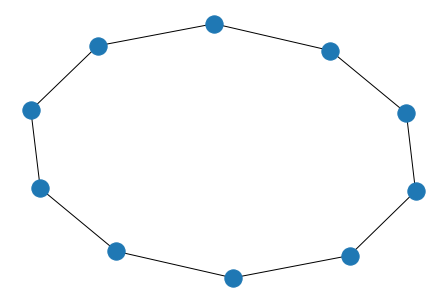

In [28]:
nx.draw(g.nodes[0]["BS"])

{'fitness': 1}


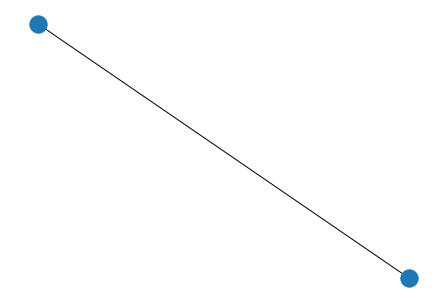

In [187]:
g = nx.Graph()
g.add_node(1)
g.node[1]["fitness"] = 1
g.add_node(2, **{"fitness": 2})
g.add_edge(1,2)
nx.draw(g)
print(g.node[1])

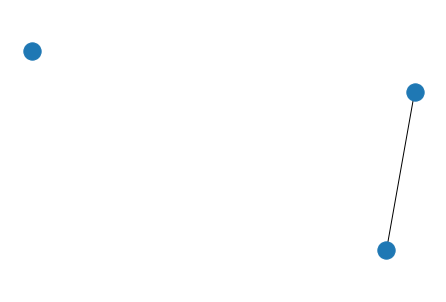

In [189]:
g.add_node(3, attr=g.node[1])
nx.draw(g)

In [190]:
g.nodes.data()

NodeDataView({1: {'fitness': 1}, 2: {'fitness': 2}, 3: {'attr': {'fitness': 1}}})